In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

# Load each sheet into separate DataFrames
# Define the file path in Google Drive

file_path = '/content/drive/MyDrive/fintech/Dataset2_Needs.xls'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Let's see the actual variables names in metadata_df
print("Metadata DataFrame columns:")
print(metadata_df.columns.tolist())

# Let's peek at the first few rows
print("\nFirst few rows of metadata:")
print(metadata_df.head())

# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


Mounted at /content/drive
Metadata DataFrame columns:
['Metadata', 'Unnamed: 1']

First few rows of metadata:
        Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components
NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


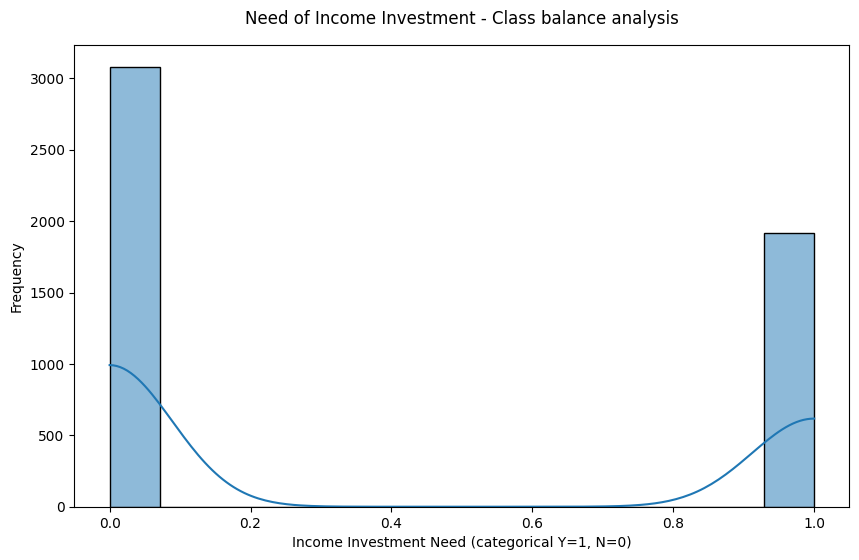

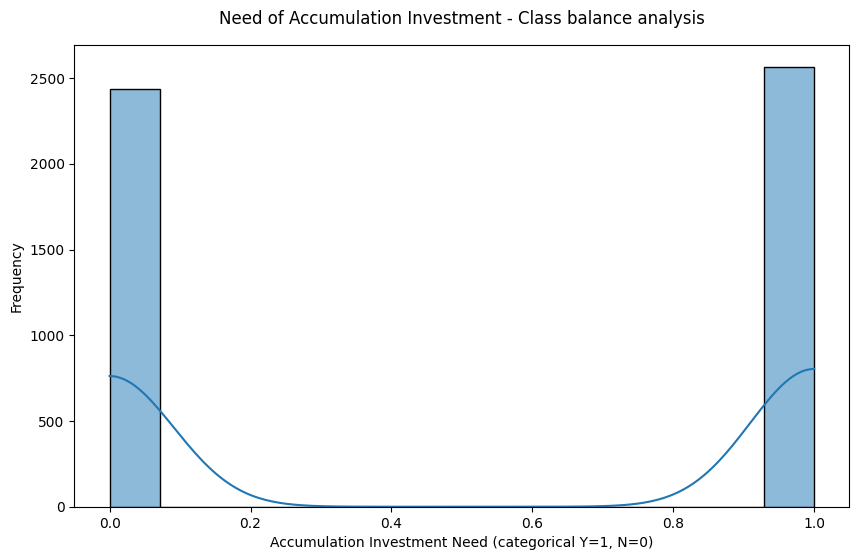

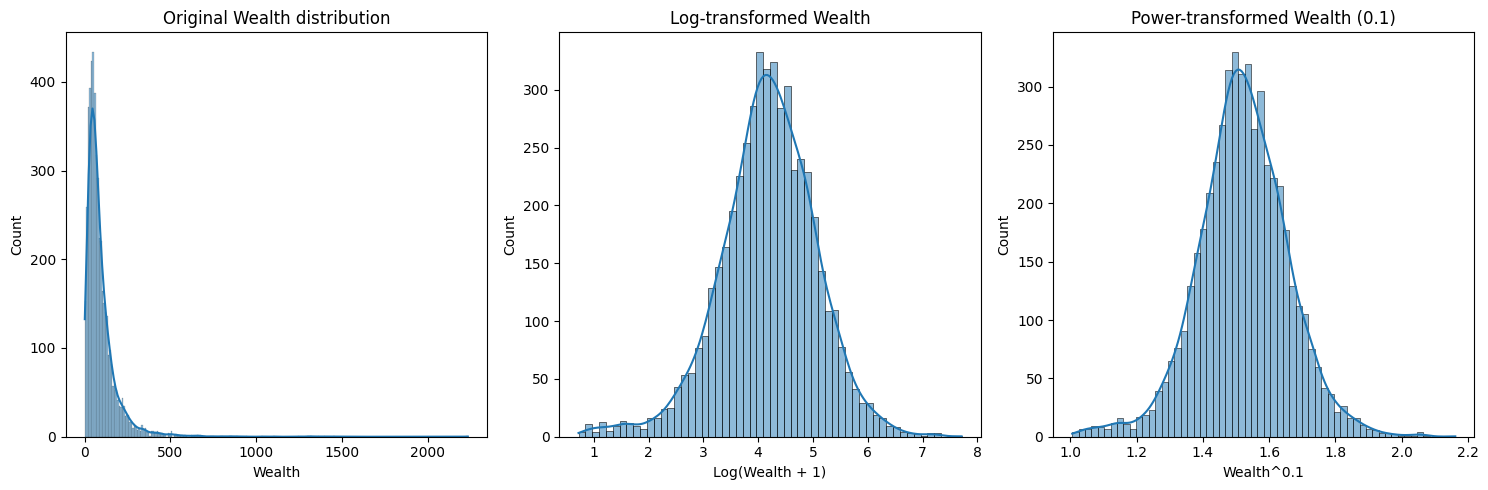

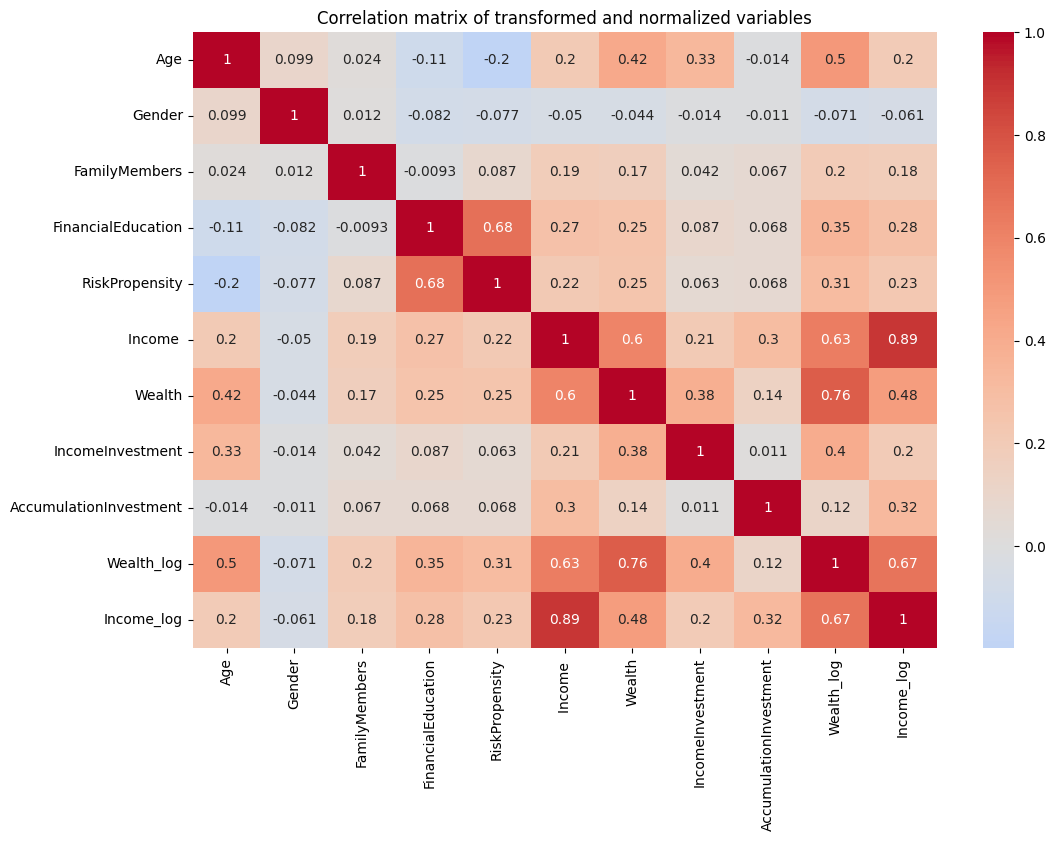

<Figure size 1500x1500 with 0 Axes>

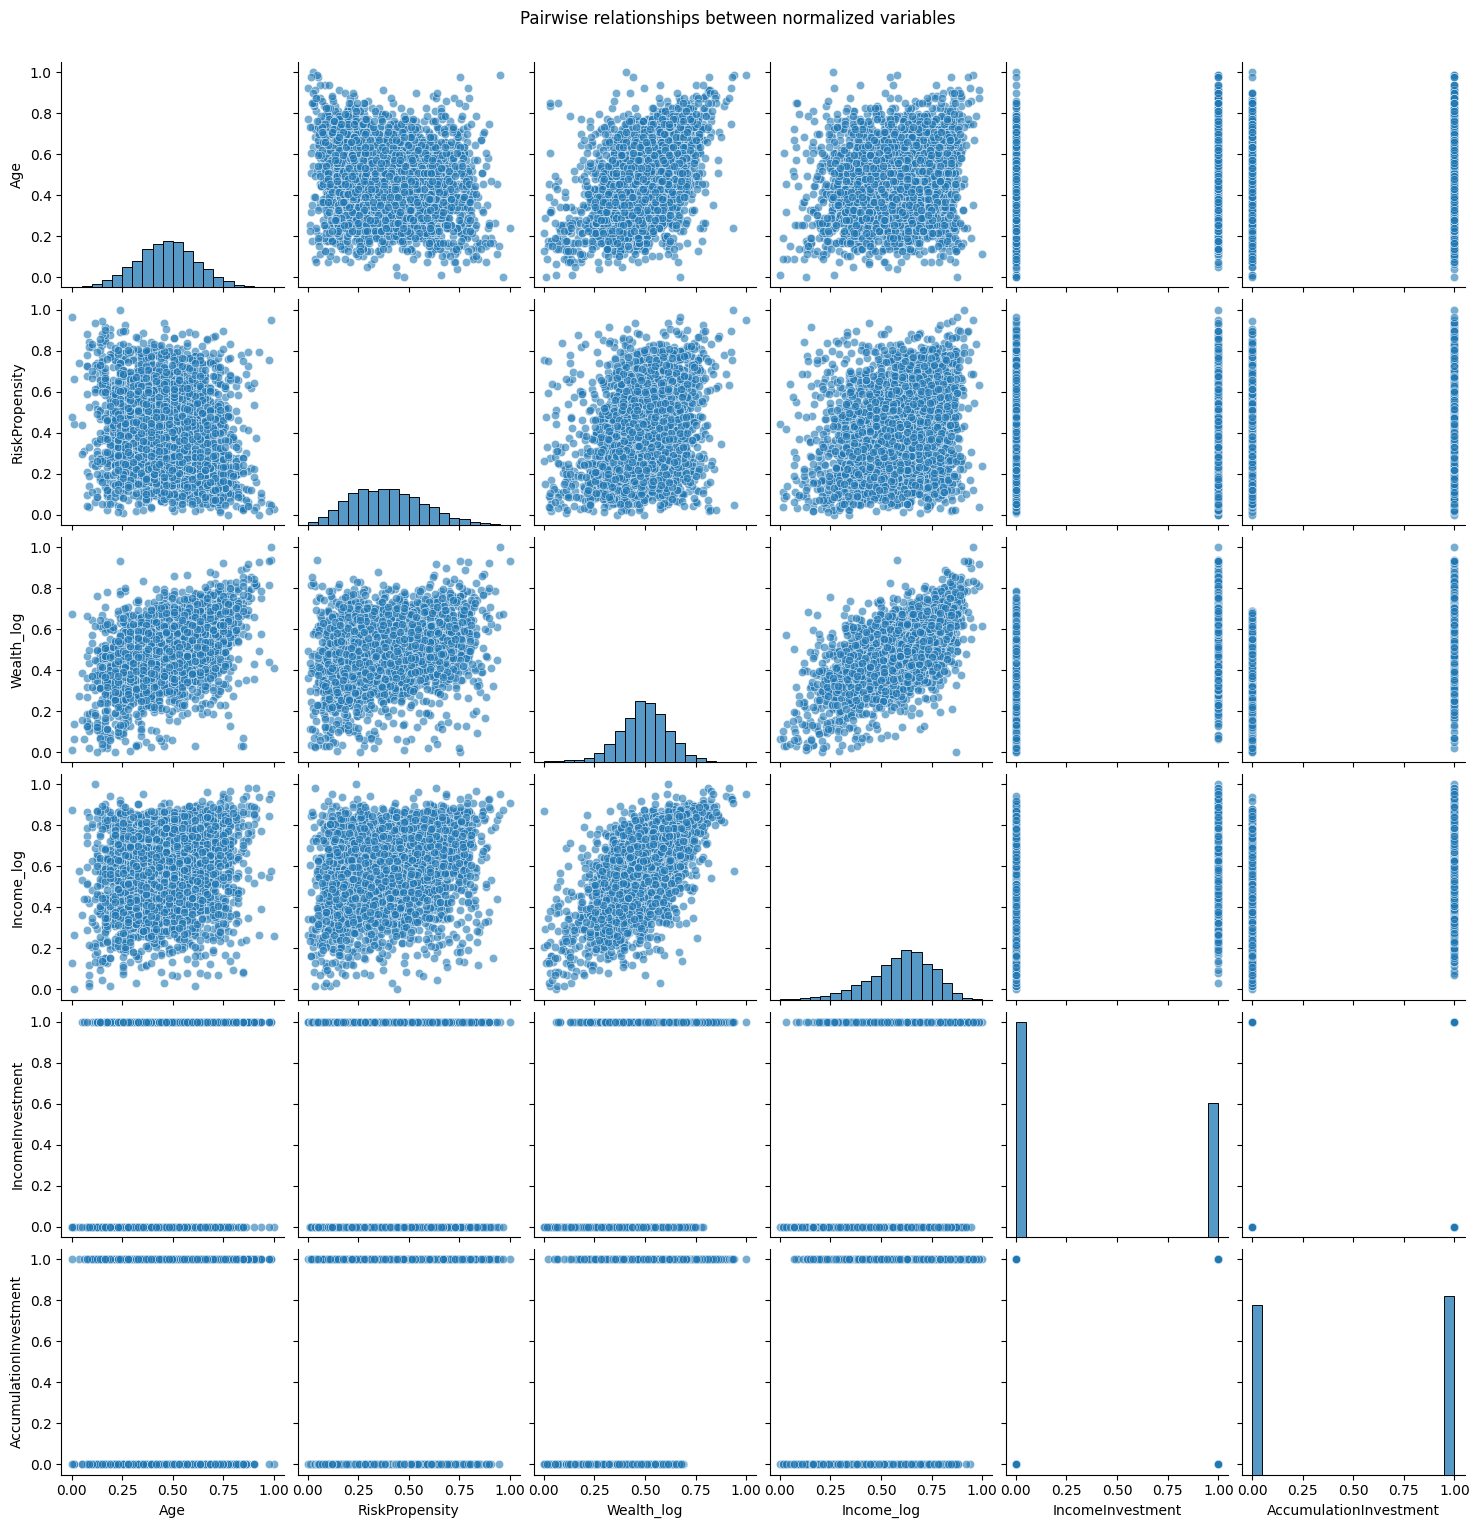

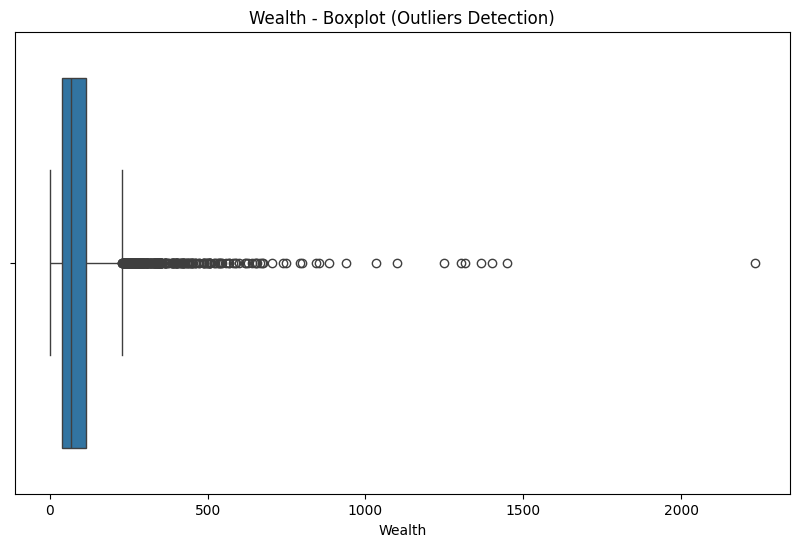

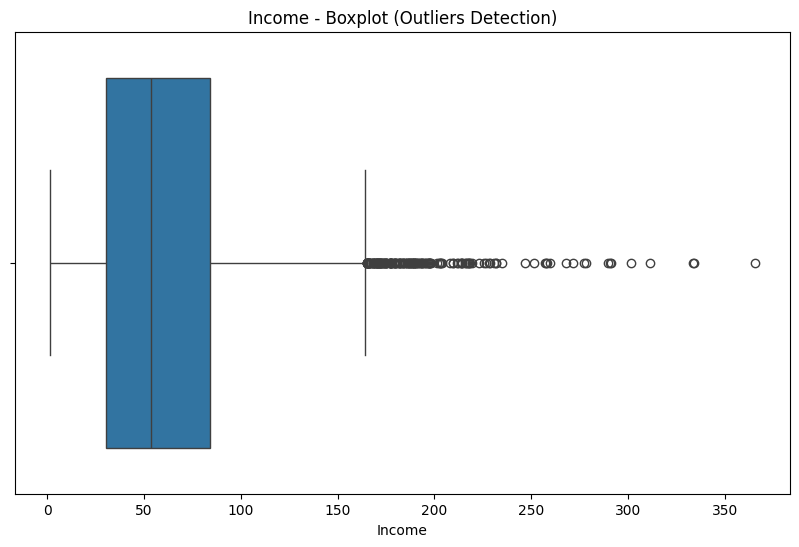

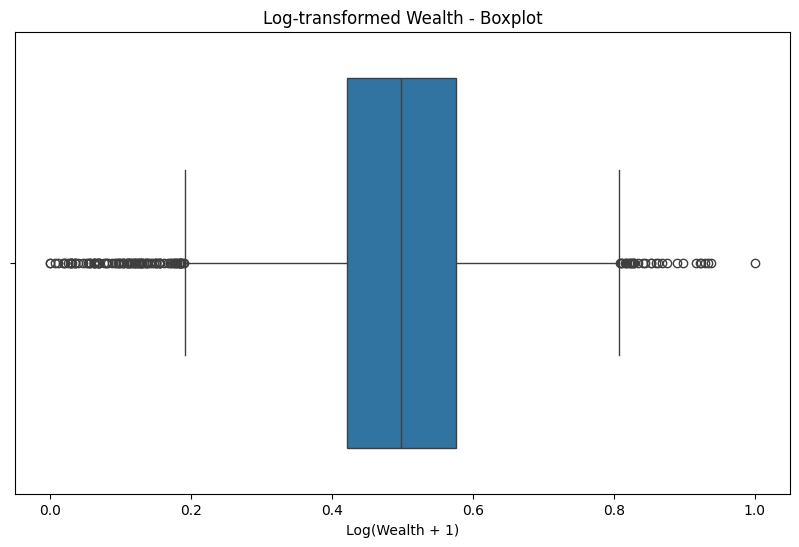

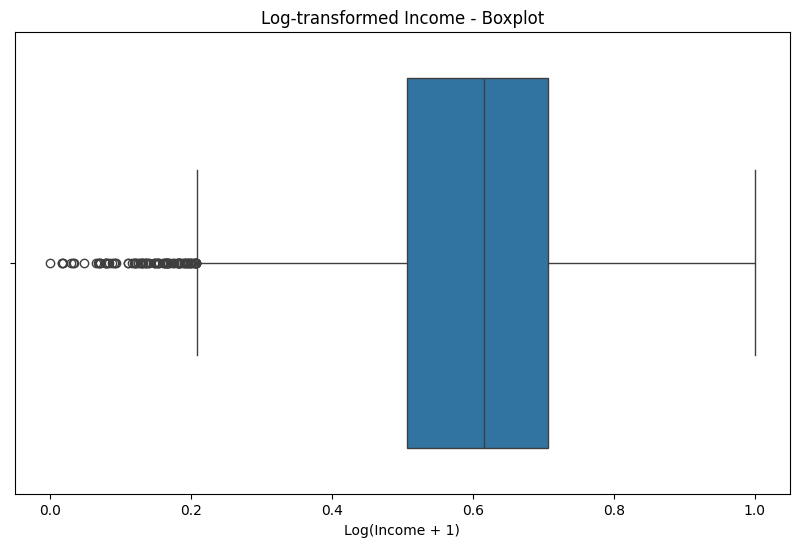

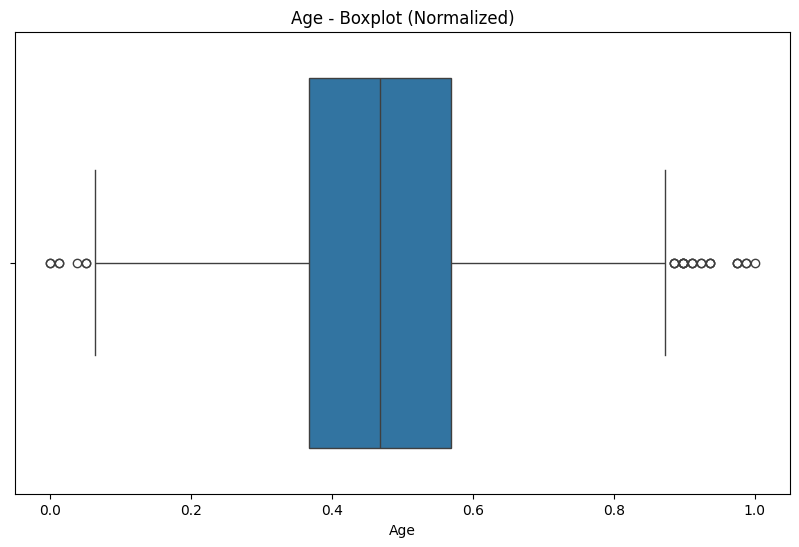

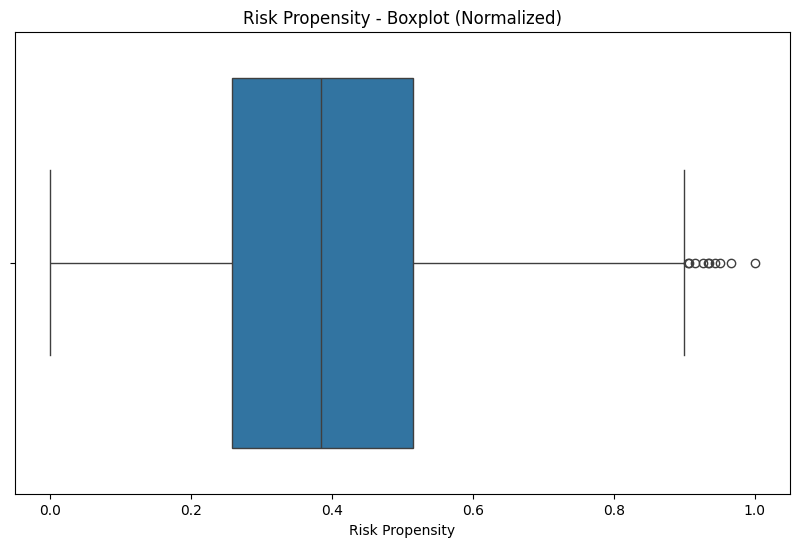

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Create df with all transformations and normalizations
transformed_df = needs_df.copy()

# Create a function for histogram plotting
def plot_histogram(data, title, xlabel, ylabel="Frequency"):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, kde=True)
    plt.title(title, pad=15)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# Plot class balance histograms
plot_histogram(needs_df.IncomeInvestment,
              'Need of Income Investment - Class balance analysis',
              'Income Investment Need (categorical Y=1, N=0)')

plot_histogram(needs_df.AccumulationInvestment,
              'Need of Accumulation Investment - Class balance analysis',
              'Accumulation Investment Need (categorical Y=1, N=0)')

# Wealth transformation analysis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original distribution
sns.histplot(needs_df.Wealth, kde=True, ax=ax1)
ax1.set_title('Original Wealth distribution')
ax1.set_xlabel('Wealth')

# Log transformation
sns.histplot(np.log1p(needs_df.Wealth), kde=True, ax=ax2)
ax2.set_title('Log-transformed Wealth')
ax2.set_xlabel('Log(Wealth + 1)')

# Power transformation
sns.histplot(np.power(needs_df.Wealth, 0.1), kde=True, ax=ax3)
ax3.set_title('Power-transformed Wealth (0.1)')
ax3.set_xlabel('Wealth^0.1')

plt.tight_layout()
plt.show()

# Apply log transformations
transformed_df['Wealth_log'] = np.log1p(transformed_df['Wealth'])
transformed_df['Income_log'] = np.log1p(transformed_df['Income '])

# Apply MinMaxScaler to numerical variables
scaler = MinMaxScaler()
vars_to_normalize = ['Age', 'RiskPropensity', 'Wealth_log', 'Income_log']
transformed_df[vars_to_normalize] = scaler.fit_transform(transformed_df[vars_to_normalize])

# Get all numeric columns including transformed ones (and not transformed, for comparison)
numeric_cols = transformed_df.select_dtypes(include=['float64', 'int64']).columns

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(transformed_df[numeric_cols].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation matrix of transformed and normalized variables')
plt.show()

# Create enhanced pairplot
vars_to_plot = vars_to_normalize + ['IncomeInvestment', 'AccumulationInvestment']
plt.figure(figsize=(15, 15))
sns.pairplot(transformed_df[vars_to_plot],
             diag_kind='hist',
             plot_kws={'alpha': 0.6},
             diag_kws={'bins': 20})
plt.suptitle('Pairwise relationships between normalized variables', y=1.02)
plt.show()

def plot_boxplot(data, title, xlabel):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

# Plot boxplots for original variables
plot_boxplot(needs_df['Wealth'], 'Wealth - Boxplot (Outliers Detection)', 'Wealth')
plot_boxplot(needs_df['Income '], 'Income - Boxplot (Outliers Detection)', 'Income')

# Plot boxplots for transformed variables
plot_boxplot(transformed_df['Wealth_log'], 'Log-transformed Wealth - Boxplot', 'Log(Wealth + 1)')
plot_boxplot(transformed_df['Income_log'], 'Log-transformed Income - Boxplot', 'Log(Income + 1)')

# Boxplots for normalized variables
plot_boxplot(transformed_df['Age'], 'Age - Boxplot (Normalized)', 'Age')
plot_boxplot(transformed_df['RiskPropensity'], 'Risk Propensity - Boxplot (Normalized)', 'Risk Propensity')


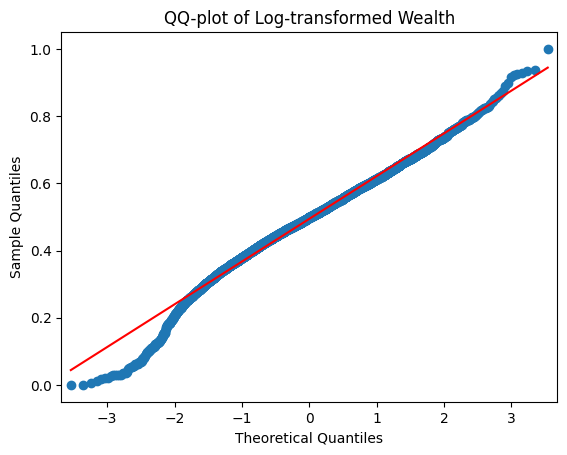

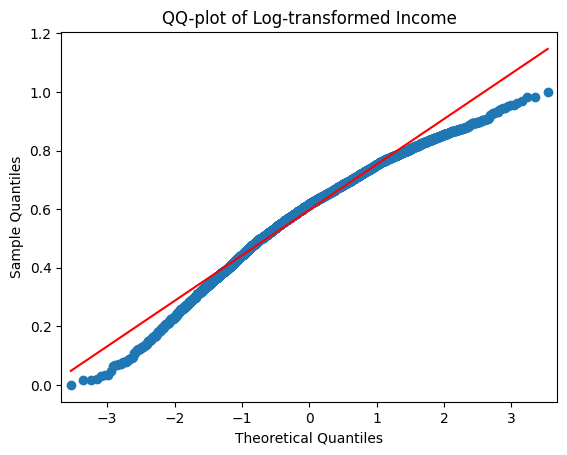

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Generate QQ-plot for Wealth_log
fig = sm.qqplot(transformed_df['Wealth_log'], line = 's')
plt.title('QQ-plot of Log-transformed Wealth')
plt.show()

fig = sm.qqplot(transformed_df['Income_log'], line='s')
plt.title('QQ-plot of Log-transformed Income')
plt.show()


In [4]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Step 1: Feature engineering and transformation function

def prepare_features(df):
    X = df.copy()

    # Fix column name inconsistency
    X.rename(columns={'Income ': 'Income'}, inplace=True)  # Remove trailing space

    # Log transformation for Wealth and Income
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income'])

    # Create Income/Wealth ratio
    X['Income_Wealth_Ratio'] = X['Income'].div(X['Wealth'].replace(0, np.nan)).fillna(X['Income'].max())
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'])

    # Age group categorization
    X['Age_Group'] = pd.cut(X['Age'], bins=[0, 30, 40, 50, 60, 70, 100],
                            labels=['<30', '30-40', '40-50', '50-60', '60-70', '70+'])

    # Feature Engineering
    X['Years_to_Retirement'] = np.clip(65 - X['Age'], 0, None)  # Assume retirement at 65
    X['Age_Risk_Interaction'] = X['Age'] * X['RiskPropensity']  # Interaction feature
    X['Income_Edu_Interaction'] = X['Income_log'] * X['FinancialEducation']  # Higher education + income
    X['FinEdu_Risk_Interaction'] = X['FinancialEducation'] / X['RiskPropensity']  # Financial education + risk tolerance
    X['Income_Wealth_Interaction'] = X['Income'] / X['Wealth_log']
    X['Wealth_Age_Interaction'] = X['Wealth_log'] * X['Age']
    X['Age_Wealth_Interaction'] = X['Age'] * X['Wealth_log']
    X['Risk_Adjusted_Wealth'] = X['Wealth_log'] * X['RiskPropensity']
    X['Fin_Readiness'] = (0.4 * X['FinancialEducation'] + 0.3 * X['RiskPropensity'] + 0.3 * X['Income_log'])
    X['Investment_Urgency'] = X['RiskPropensity'] * X['Years_to_Retirement']


    # Select features for modeling
    features_base = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                    'RiskPropensity', 'Wealth_log', 'Income_log']
    #features_base = ['Age', 'Wealth_log', 'Income_log']
    #features_base = ['Wealth_log']

    features_engineered = ['Years_to_Retirement', 'Gender', 'FamilyMembers','FinancialEducation','RiskPropensity', 'Income_log','Wealth_log']
    #features_engineered = [ 'Age_Risk_Interaction',  'Gender', 'FamilyMembers','FinancialEducation','Income_log','Wealth_log']
    #features_engineered = ['Income_Edu_Interaction', 'Age', 'Gender', 'FamilyMembers','RiskPropensity', 'Wealth_log']

    #features_engineered = [ 'FinEdu_Risk_Interaction', 'Age', 'Gender', 'FamilyMembers',   'Income_log','Wealth_log']

    #features_engineered = [  'Age', 'Gender', 'FamilyMembers','FinancialEducation',  'RiskPropensity', 'Income_Wealth_Interaction']

    #features_engineered = [  'Age', 'Gender', 'FamilyMembers','FinancialEducation',  'RiskPropensity', 'Income_Wealth_Interaction','Wealth_Age_Interaction']
    #features_engineered = [ 'Age', 'Gender', 'FamilyMembers','FinancialEducation','Years_to_Retirement', 'Income_Wealth_Interaction','Wealth_Age_Interaction',]

    # Normalize all features
    scaler = MinMaxScaler()
    X_base = pd.DataFrame(scaler.fit_transform(X[features_base]), columns=features_base)
    X_engineered = pd.DataFrame(scaler.fit_transform(X[features_engineered]), columns=features_engineered)

    return X_base, X_engineered



# Step 2: Data split function
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Step 3: Model training and evaluation function
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        }
    }

# Step 4: Display results function
def display_results_table(results_dict, model_name, feature_type):
    cv_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'CV Mean': [
            results_dict['cv_metrics']['accuracy']['mean'],
            results_dict['cv_metrics']['precision']['mean'],
            results_dict['cv_metrics']['recall']['mean'],
            results_dict['cv_metrics']['f1']['mean']
        ],
        'CV Std': [
            results_dict['cv_metrics']['accuracy']['std'],
            results_dict['cv_metrics']['precision']['std'],
            results_dict['cv_metrics']['recall']['std'],
            results_dict['cv_metrics']['f1']['std']
        ],
        'Test Set': [
            results_dict['test_metrics']['accuracy'],
            results_dict['test_metrics']['precision'],
            results_dict['test_metrics']['recall'],
            results_dict['test_metrics']['f1']
        ]
    }

    df = pd.DataFrame(cv_data)
    df = df.round(3)

    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty'))

# Step 5: Run full analysis
# Prepare features
X_base, X_engineered = prepare_features(needs_df)
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']

# Define models
models = {
    'SVM': SVC(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression()
}

# Actually run analysis and display results
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    for model_name, model in models.items():
        results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
        display_results_table(results_base, model_name, "Base Features")

        results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
        display_results_table(results_eng, model_name, "Engineered Features")



Target Variable: Income Investment

SVM - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.771  | 0.015  |  0.747   |
| 1 | Precision |  0.816  | 0.011  |  0.796   |
| 2 |  Recall   |  0.521  |  0.04  |  0.458   |
| 3 |    F1     |  0.635  | 0.027  |  0.582   |
+---+-----------+---------+--------+----------+

SVM - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.77   | 0.014  |  0.748   |
| 1 | Precision |  0.803  | 0.007  |  0.784   |
| 2 |  Recall   |  0.529  | 0.034  |  0.474   |
| 3 |    F1     |  0.637  | 0.024  |  0.591   |
+---+-----------+---------+--------+----------+

NaiveBayes - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+-------

In [5]:
import xgboost as xgb

# Updated XGBoost configuration
models = {
    'XGBoost': xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    )
}

# Run the analysis
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)

    model = models['XGBoost']

    results_base = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
    display_results_table(results_base, 'XGBoost', "Base Features")

    results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, model)
    display_results_table(results_eng, 'XGBoost', "Engineered Features")



Target Variable: Income Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.786  | 0.018  |  0.759   |
| 1 | Precision |  0.778  | 0.017  |   0.76   |
| 2 |  Recall   |  0.621  | 0.031  |  0.544   |
| 3 |    F1     |  0.69   | 0.025  |  0.634   |
+---+-----------+---------+--------+----------+

XGBoost - Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.782  | 0.017  |  0.748   |
| 1 | Precision |  0.765  | 0.015  |  0.726   |
| 2 |  Recall   |  0.622  | 0.037  |  0.552   |
| 3 |    F1     |  0.686  | 0.026  |  0.627   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

XGBoost - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean

Feature Importance analysis and SHAPE values


Feature Importance for Income Investment
features base


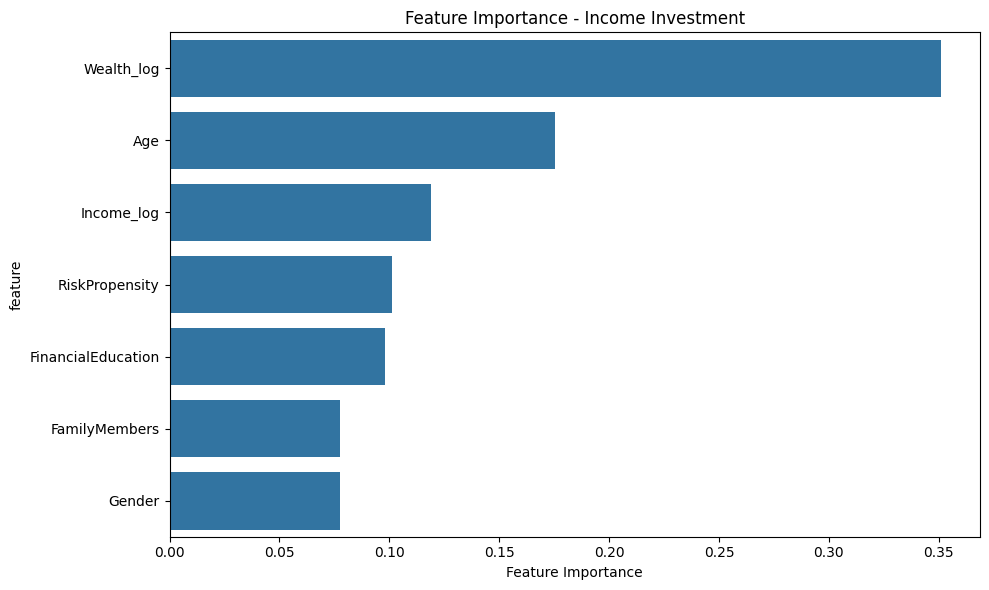

features engineered


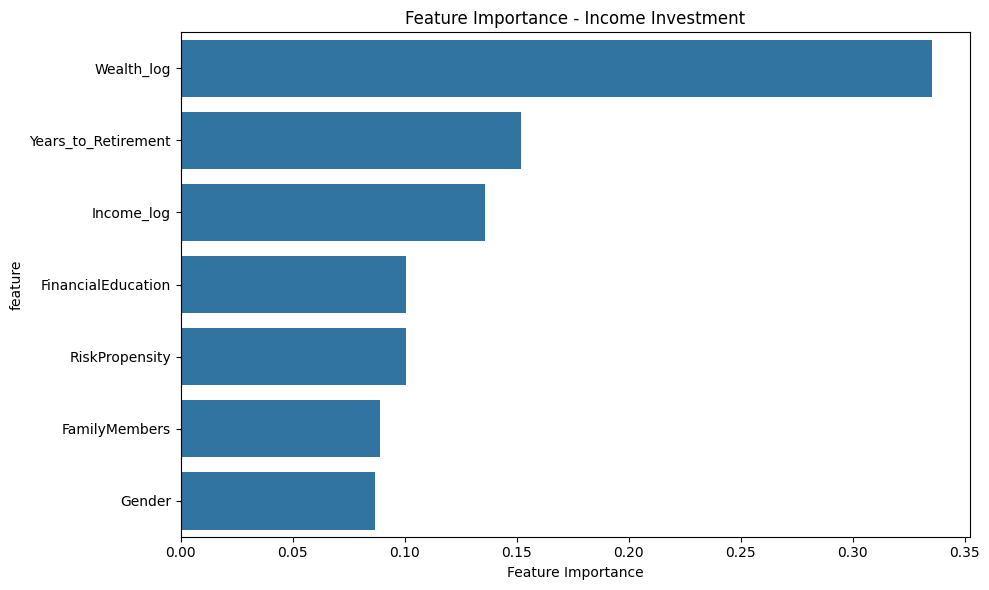


Feature Importance for Accumulation Investment
features base


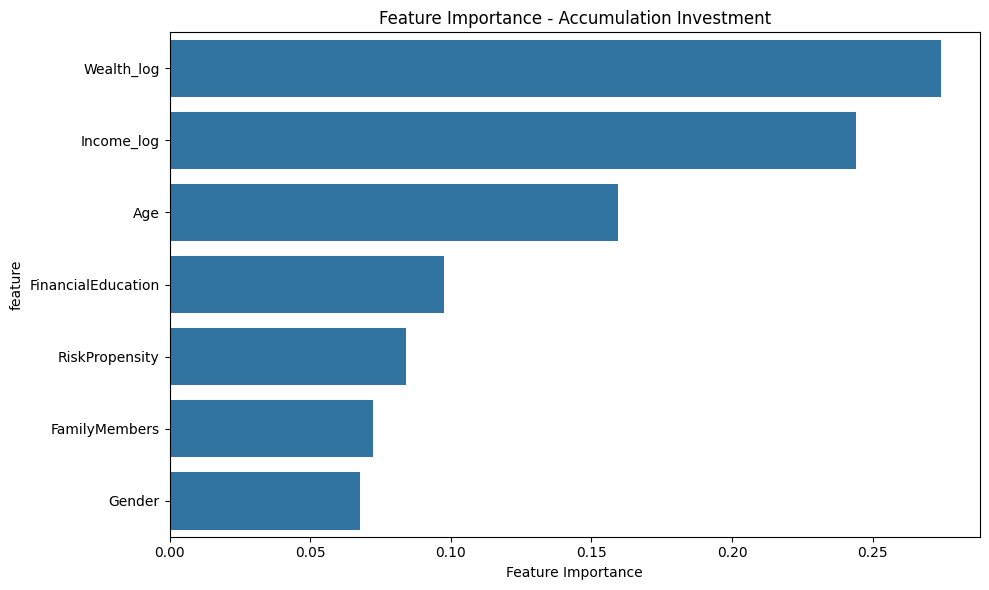

features engineered


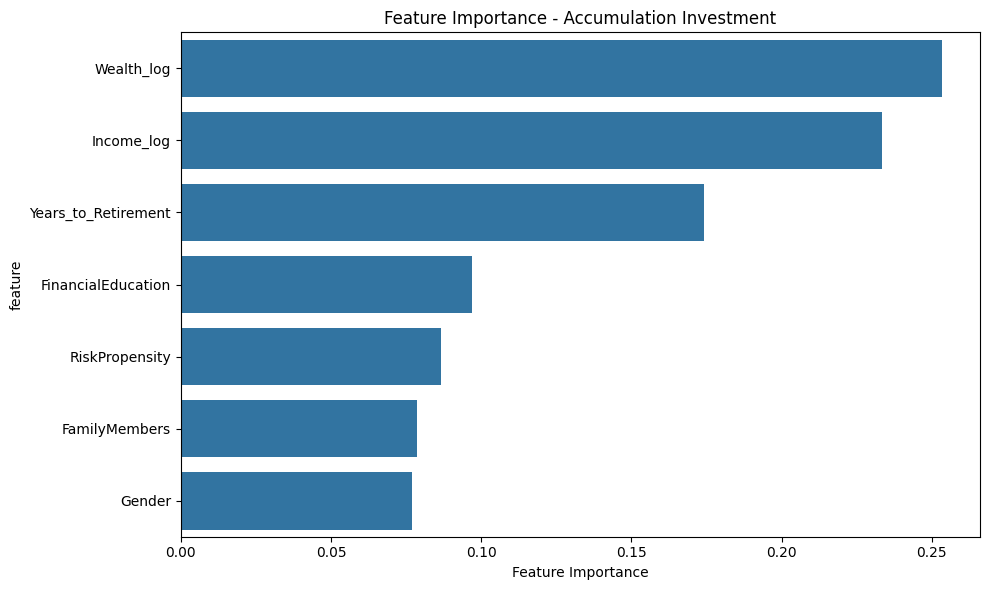

In [6]:
# Rewrite the function, returning the trained model, too
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        },
        'model': model
    }


# Feature importance function: capture the trained models during our initial
# training phase and then use them for feature importance analysis
def plot_feature_importance(model, feature_names, title):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

# Define models
models = {
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

# Run analysis and plot feature importance
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nFeature Importance for {target_name}")
    print("=" * 50)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)
    results = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, models['XGBoost'])
    print("features base")
    plot_feature_importance(results['model'], X_base.columns, f'Feature Importance - {target_name}')

    result_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, models['XGBoost'])
    print("features engineered")
    plot_feature_importance(result_eng['model'], X_engineered.columns, f'Feature Importance - {target_name}')



SHAP Analysis for Income Investment
--------------------------------------base-------------------------------------------


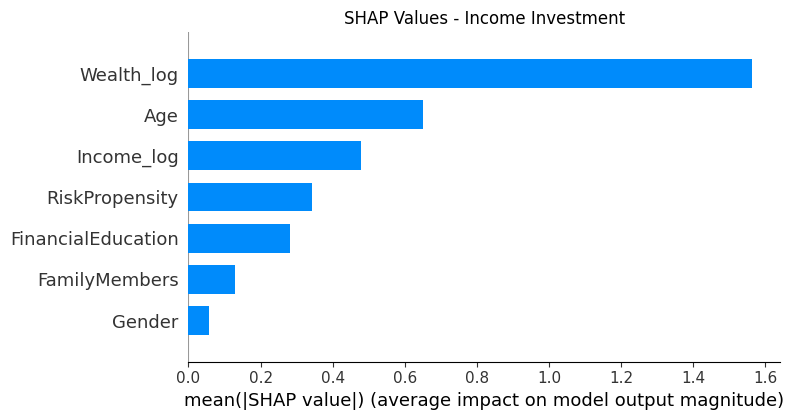

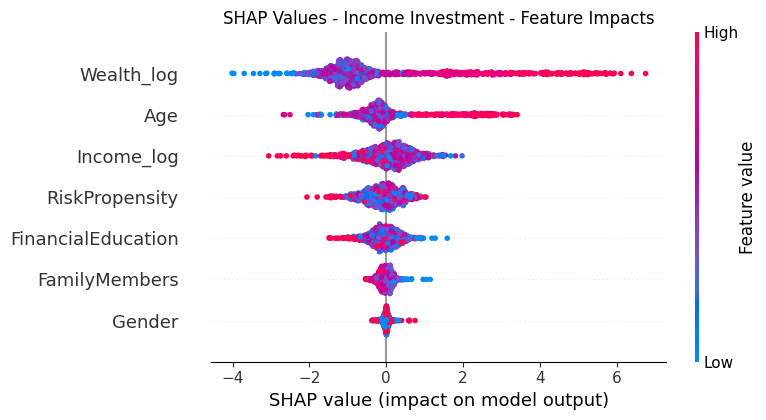

--------------------------------------engineered-------------------------------------------


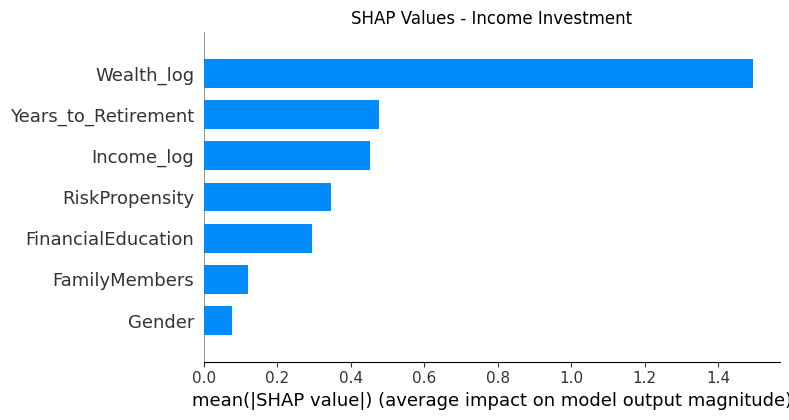

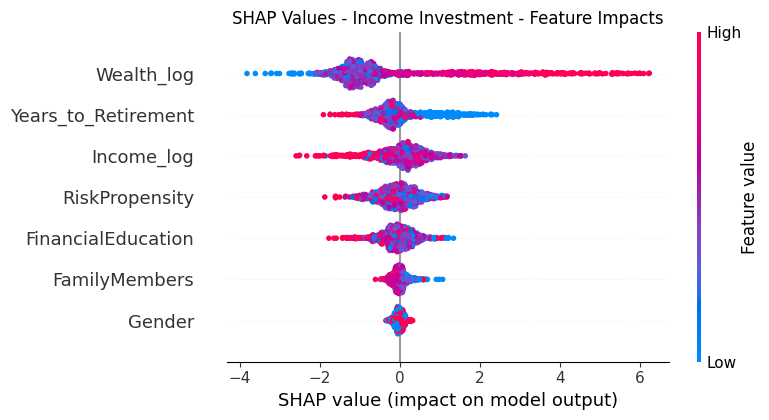


SHAP Analysis for Accumulation Investment
--------------------------------------base-------------------------------------------


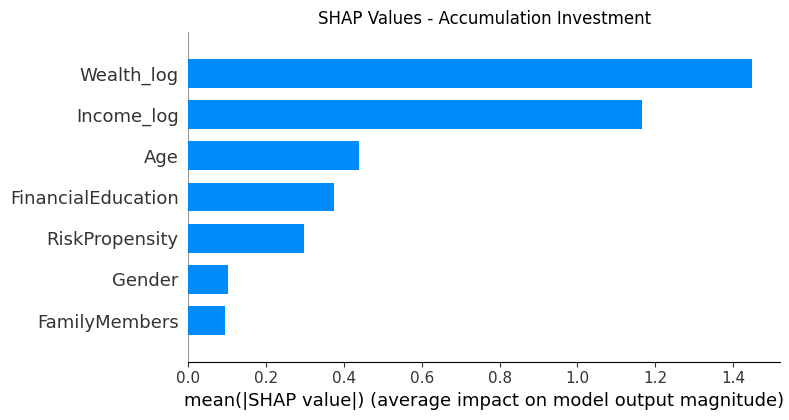

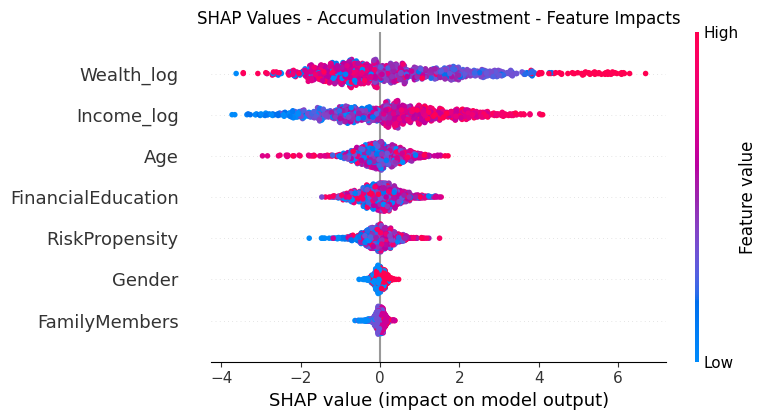

--------------------------------------engineered-------------------------------------------


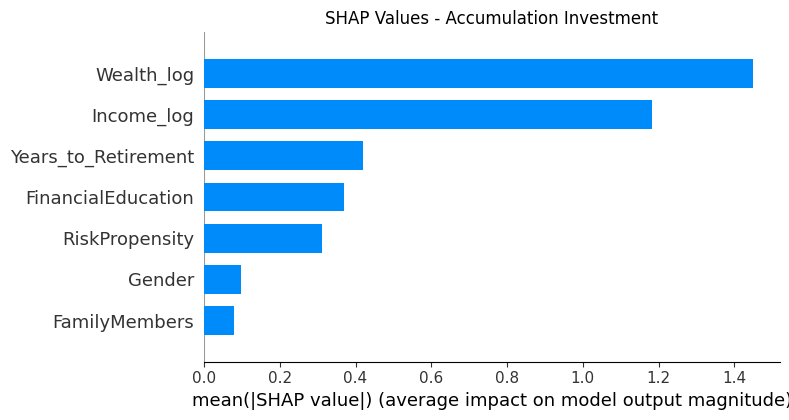

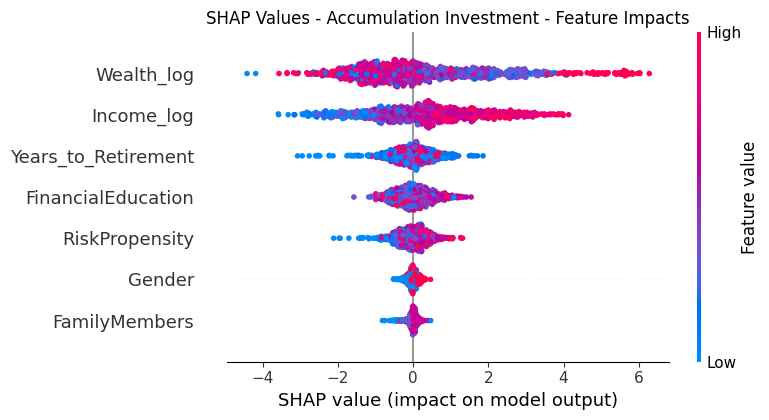

In [7]:
import shap

def plot_shap_values(model, X, title):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"{title} - Feature Impacts")
    plt.tight_layout()
    plt.show()

# Calculate and plot SHAP values for both targets
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nSHAP Analysis for {target_name}")
    print("=" * 50)

    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    X_eng_train, X_eng_test, _, _ = split_data(X_engineered, y)
    print("--------------------------------------base-------------------------------------------")
    results = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, models['XGBoost'])
    plot_shap_values(results['model'], X_base_test, f'SHAP Values - {target_name}')
    print("--------------------------------------engineered-------------------------------------------")
    results_eng = train_evaluate_model(X_eng_train, y_train, X_eng_test, y_test, models['XGBoost'])
    plot_shap_values(results_eng['model'], X_eng_test, f'SHAP Values - {target_name}')



    '''
    Cosa notiamo:

Wealth_log: valori alti (rosso) spingono molto verso predizioni alte (verso destra), mentre valori bassi (blu) spingono verso predizioni basse → intuitivo: più sei ricco, più investi.

Age: ha un effetto positivo crescente → gli individui più anziani (rosso) tendono a investire di più.

Income_log: comportamento simile alla ricchezza, ma impatto minore.

RiskPropensity: chi ha alta propensione al rischio (rosso) tende a investire di più.

FinancialEducation: alto livello di educazione finanziaria (rosso) è associato a un impatto positivo sul modello.

FamilyMembers: effetto più limitato ma un po' disperso – forse chi ha meno membri in famiglia tende a investire leggermente di più.

Gender: ha l’impatto più basso e variabilità limitata – probabilmente il modello non trova molta differenza predittiva tra generi.

✅ Conclusioni principali
Le variabili economiche (ricchezza, reddito) sono molto più determinanti rispetto a quelle demografiche come sesso o numero di familiari.

La propensione al rischio e l’educazione finanziaria sono anch’esse rilevanti, suggerendo che atteggiamenti e competenze individuali giocano un ruolo importante.

Le SHAP values aiutano a rendere il modello interpretabile e forniscono insight utili per la personalizzazione delle strategie (es. marketing, consulenza finanziaria).
    '''


In [10]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(16, 1),
            nn.Sigmoid()  # Per classificazione binaria
        )
    def forward(self, x):
        return self.layers(x)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, '
                  f'Val Loss: {val_loss/len(val_loader):.4f}, '
                  f'Val Accuracy: {accuracy_score(val_true, val_preds):.4f}')


# Supponiamo di avere già l'ordine corretto (come da grafico SHAP)
feature_importance = np.array([0.17, 0.07, 0.08, 0.11, 0.09, 0.27, 0.23])  # somma = 1
X_weighted = X_base * feature_importance

# Use the same data split as before
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTraining Neural Network for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)

    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model, criterion, optimizer
    model = MLP(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    # Train model
    train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100)



Training Neural Network for Income Investment
Epoch 10, Train Loss: 0.5283, Val Loss: 0.5455, Val Accuracy: 0.7500
Epoch 20, Train Loss: 0.5072, Val Loss: 0.5394, Val Accuracy: 0.7580
Epoch 30, Train Loss: 0.5175, Val Loss: 0.5361, Val Accuracy: 0.7590
Epoch 40, Train Loss: 0.5072, Val Loss: 0.5355, Val Accuracy: 0.7560
Epoch 50, Train Loss: 0.4992, Val Loss: 0.5322, Val Accuracy: 0.7600
Epoch 60, Train Loss: 0.5115, Val Loss: 0.5339, Val Accuracy: 0.7640
Epoch 70, Train Loss: 0.5050, Val Loss: 0.5273, Val Accuracy: 0.7670
Epoch 80, Train Loss: 0.5001, Val Loss: 0.5340, Val Accuracy: 0.7560
Epoch 90, Train Loss: 0.4985, Val Loss: 0.5241, Val Accuracy: 0.7660
Epoch 100, Train Loss: 0.4927, Val Loss: 0.5284, Val Accuracy: 0.7610

Training Neural Network for Accumulation Investment
Epoch 10, Train Loss: 0.5666, Val Loss: 0.5487, Val Accuracy: 0.7210
Epoch 20, Train Loss: 0.5403, Val Loss: 0.5030, Val Accuracy: 0.7660
Epoch 30, Train Loss: 0.5268, Val Loss: 0.4913, Val Accuracy: 0.7740
Ep

In [11]:
# Model evaluation
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())
            all_true.extend(y_batch.numpy())

    return {
        'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds)
    }

# Evaluate and display results
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nResults for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)

    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get metrics
    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    # Display results
    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)




Results for Income Investment

Neural Network Metrics:
           Training   Test
accuracy      0.530  0.526
precision     0.399  0.404
recall        0.447  0.492
f1            0.421  0.444

Results for Accumulation Investment

Neural Network Metrics:
           Training   Test
accuracy      0.828  0.780
precision     0.895  0.819
recall        0.753  0.733
f1            0.818  0.774


In [12]:
# Enhanced MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Training with learning rate scheduler
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy_score(val_true, val_preds))

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val Accuracy: {val_accuracies[-1]:.4f}')

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Training Neural Network for Income Investment
Epoch 10, Train Loss: 0.5251, Val Loss: 0.5383, Val Accuracy: 0.7560
Epoch 20, Train Loss: 0.5131, Val Loss: 0.5390, Val Accuracy: 0.7550
Epoch 30, Train Loss: 0.4924, Val Loss: 0.5292, Val Accuracy: 0.7620
Epoch 40, Train Loss: 0.4903, Val Loss: 0.5287, Val Accuracy: 0.7640
Epoch 50, Train Loss: 0.4891, Val Loss: 0.5289, Val Accuracy: 0.7650
Epoch 60, Train Loss: 0.4934, Val Loss: 0.5289, Val Accuracy: 0.7670
Epoch 70, Train Loss: 0.4880, Val Loss: 0.5294, Val Accuracy: 0.7660
Epoch 80, Train Loss: 0.4827, Val Loss: 0.5342, Val Accuracy: 0.7600
Epoch 90, Train Loss: 0.4823, Val Loss: 0.5351, Val Accuracy: 0.7620
Epoch 100, Train Loss: 0.4735, Val Loss: 0.5320, Val Accuracy: 0.7640


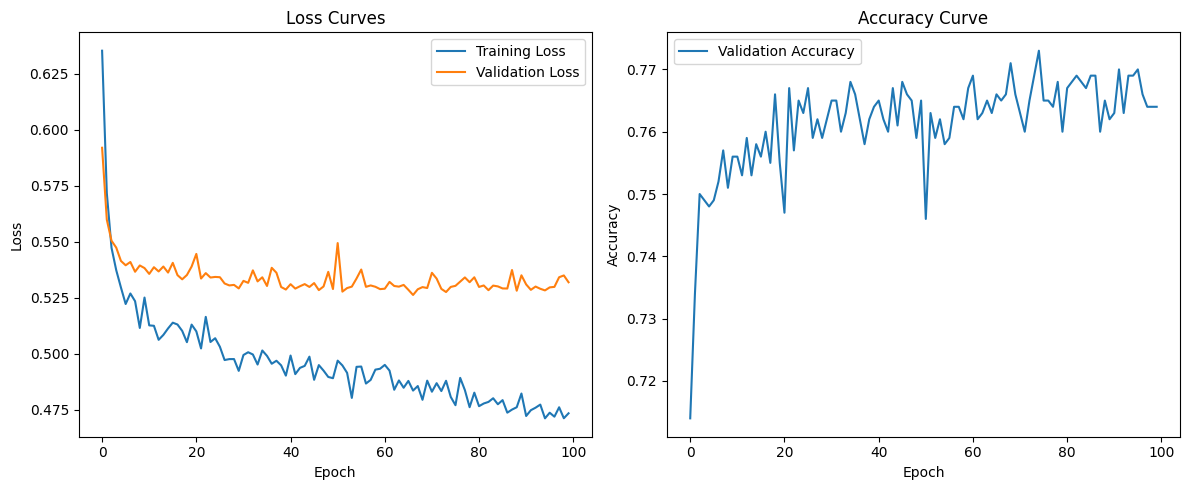


Results for Income Investment

Neural Network Metrics:
           Training   Test
accuracy      0.818  0.764
precision     0.853  0.787
recall        0.633  0.529
f1            0.727  0.632

Training Neural Network for Accumulation Investment
Epoch 10, Train Loss: 0.5541, Val Loss: 0.5365, Val Accuracy: 0.7400
Epoch 20, Train Loss: 0.5103, Val Loss: 0.4977, Val Accuracy: 0.7510
Epoch 30, Train Loss: 0.4925, Val Loss: 0.4747, Val Accuracy: 0.7790
Epoch 40, Train Loss: 0.4909, Val Loss: 0.4780, Val Accuracy: 0.7680
Epoch 50, Train Loss: 0.4788, Val Loss: 0.4658, Val Accuracy: 0.7830
Epoch 60, Train Loss: 0.4751, Val Loss: 0.4603, Val Accuracy: 0.7900
Epoch 70, Train Loss: 0.4679, Val Loss: 0.4606, Val Accuracy: 0.7810
Epoch 80, Train Loss: 0.4715, Val Loss: 0.4616, Val Accuracy: 0.7830
Epoch 90, Train Loss: 0.4610, Val Loss: 0.4568, Val Accuracy: 0.7900
Epoch 100, Train Loss: 0.4653, Val Loss: 0.4601, Val Accuracy: 0.7920


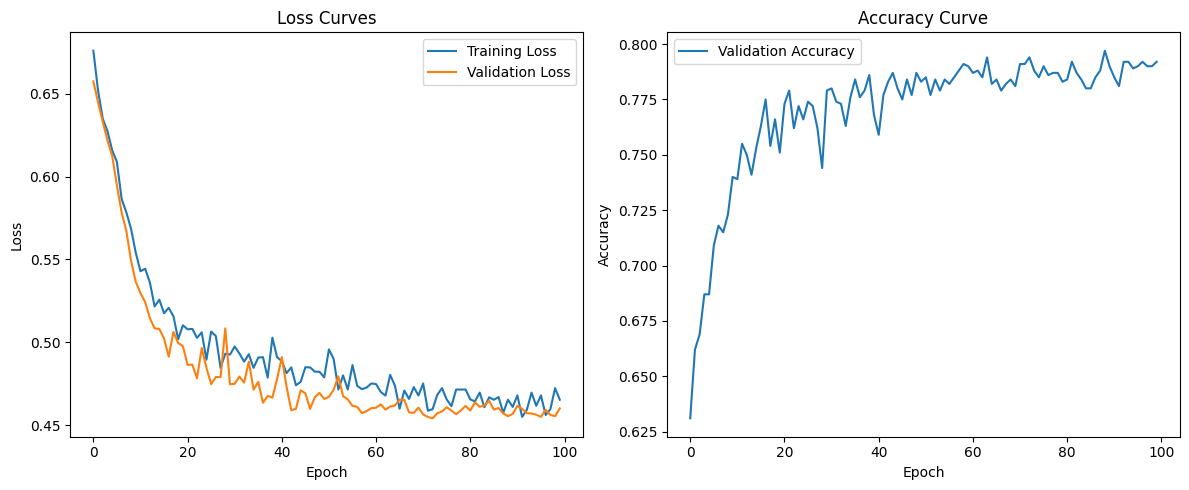


Results for Accumulation Investment

Neural Network Metrics:
           Training   Test
accuracy      0.826  0.792
precision     0.889  0.832
recall        0.754  0.745
f1            0.816  0.786


In [13]:
# Training and evaluation for both targets
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTraining Neural Network for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)

    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model, criterion, optimizer
    model = MLP(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

    # Display final metrics
    print(f"\nResults for {target_name}")
    print("=" * 50)

    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)



Training the enhanced MLP model (Accumulation Investment)
Epoch 10, Train Loss: 0.5598, Val Loss: 0.5310, Val Accuracy: 0.7360
Epoch 20, Train Loss: 0.5176, Val Loss: 0.5019, Val Accuracy: 0.7520
Epoch 30, Train Loss: 0.5072, Val Loss: 0.4833, Val Accuracy: 0.7790
Epoch 40, Train Loss: 0.5063, Val Loss: 0.4785, Val Accuracy: 0.7760
Epoch 50, Train Loss: 0.5073, Val Loss: 0.4861, Val Accuracy: 0.7800
Epoch 60, Train Loss: 0.4916, Val Loss: 0.4705, Val Accuracy: 0.7900
Epoch 70, Train Loss: 0.4945, Val Loss: 0.4817, Val Accuracy: 0.7770
Epoch 80, Train Loss: 0.4973, Val Loss: 0.4704, Val Accuracy: 0.7880
Epoch 90, Train Loss: 0.4978, Val Loss: 0.4683, Val Accuracy: 0.7830
Epoch 100, Train Loss: 0.4806, Val Loss: 0.4665, Val Accuracy: 0.7830


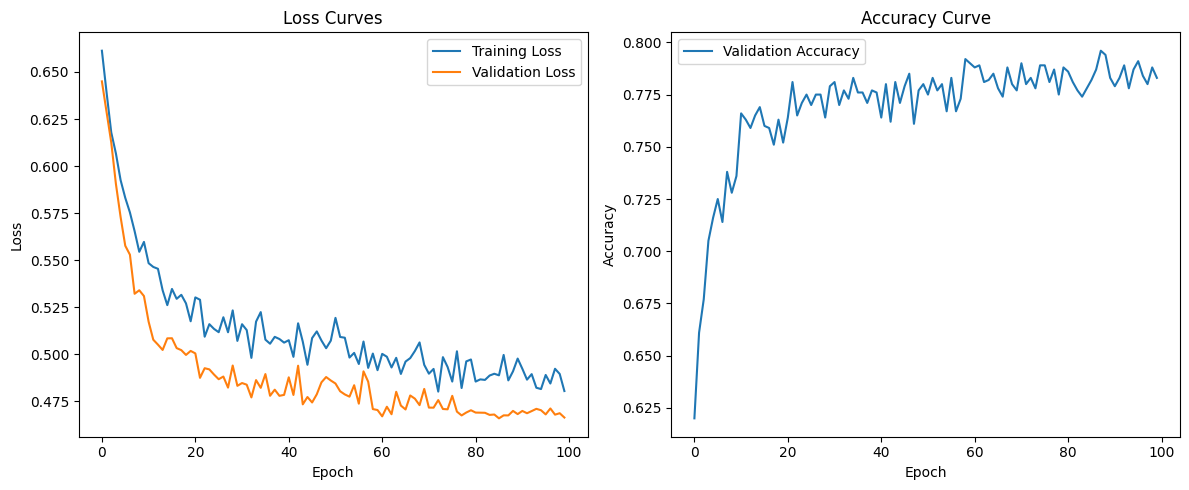

In [14]:
from re import X
# Let's modify the Investment Dataset class to handle both Pandas and PyTorch
class InvestmentDatasetFixed(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        # Check if y is already a tensor or needs to be converted
        if isinstance(y, torch.Tensor):
            self.y = y
        else:
            self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to get predictions from the enhanced MLP model (i.e., the last estimated one)
def get_predictions_from_mlp(model, X_test):
    # Create a dataset and dataloader for predictions
    dummy_y = pd.Series(np.zeros(len(X_test)))  # Creating a Panda series
    test_dataset = InvestmentDatasetFixed(X_test, dummy_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get predictions
    model.eval()
    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())

    return np.array(all_preds)

# Filtering accumulation products from our product database
accumulation_products = products_df[products_df['Type'] == 1].copy()
min_risk = accumulation_products['Risk'].min() # Will be used for risk matching later

# # Training the enhanced MLP model for accumulation investment needs prediction
print("\nTraining the enhanced MLP model (Accumulation Investment)")
print("=" * 80)

# Data preparation
X_base, X_engineered = prepare_features(needs_df)
y_accum = needs_df['AccumulationInvestment']
y_income = needs_df['IncomeInvestment']
X_train, X_test, y_train, y_test = split_data(X_base, y_accum)
X_train_eng, X_test_eng, _,_ = split_data(X_engineered, y_accum)
X_train_I, X_test_I, _,_ = split_data(X_base, y_income)
X_train_eng_I, X_test_eng_I, _,_ = split_data(X_engineered, y_income)
# Create data loaders using our improved Dataset class
train_dataset = InvestmentDatasetFixed(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = InvestmentDatasetFixed(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize and train the model with learning curves visualization
model = MLP(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

# Use the trained model to predict accumulation investment needs for the test set clients
#y_pred = get_predictions_from_mlp(model, X_test)


## now i can try to use voting tecniques


In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier

In [16]:
estimator = []
estimator.append(('Neural Network', MLPClassifier(max_iter = 10000) ))
estimator.append(('LogisticRegression', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)))
estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier() ))
estimator.append(('RandomForest', RandomForestClassifier() ))
estimator.append(('KNN', KNeighborsClassifier() ))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('AdaBoostClassifier', AdaBoostClassifier() ))
estimator.append(('GradientBoostingClassifier', GradientBoostingClassifier() ))
estimator.append(('XGB', XGBClassifier() ))


In [19]:
from sklearn.metrics import classification_report, accuracy_score
VC_soft_I = VotingClassifier(estimators = estimator, voting ='soft')
VC_soft_I_eng = VotingClassifier(estimators = estimator, voting ='soft')
VC_soft_I.fit(X_train_I, y_train)
y_pred_I = VC_soft_I.predict(X_test_I)
print(classification_report(y_test, y_pred_I))
VC_soft_I_eng.fit(X_train_eng_I, y_train)
y_pred_I_eng = VC_soft_I_eng.predict(X_test_eng_I)
print(classification_report(y_test, y_pred_I_eng))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.53      0.45      0.49       487
           1       0.55      0.62      0.58       513

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.52      0.46      0.49       487
           1       0.54      0.60      0.57       513

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



In [20]:
VC_soft = VotingClassifier(estimators = estimator, voting ='soft')
VC_soft_eng = VotingClassifier(estimators = estimator, voting ='soft')
VC_soft.fit(X_train, y_train)
y_pred = VC_soft.predict(X_test)
print(classification_report(y_test, y_pred))
VC_soft_eng.fit(X_train_eng, y_train)
y_pred_eng = VC_soft_eng.predict(X_test_eng)
print(classification_report(y_test, y_pred_eng))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.76      0.78      0.77       487
           1       0.78      0.77      0.78       513

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.77      0.77      0.77       487
           1       0.78      0.78      0.78       513

    accuracy                           0.78      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.78      0.78      0.78      1000



In [21]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
ROCAUCscore_I = roc_auc_score(y_test, y_pred_I)
print(f"AUC-ROC Curve for Voting Classifier with soft voting: {ROCAUCscore:.4f}")

AUC-ROC Curve for Voting Classifier with soft voting: 0.7749


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.

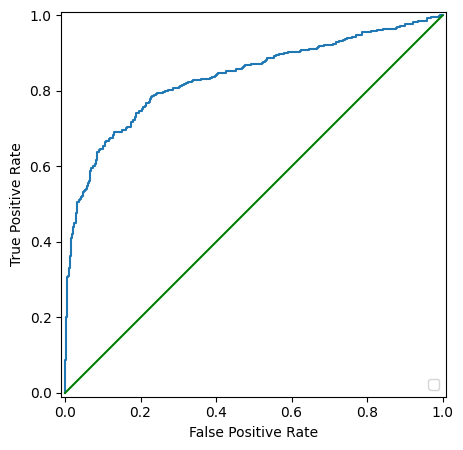

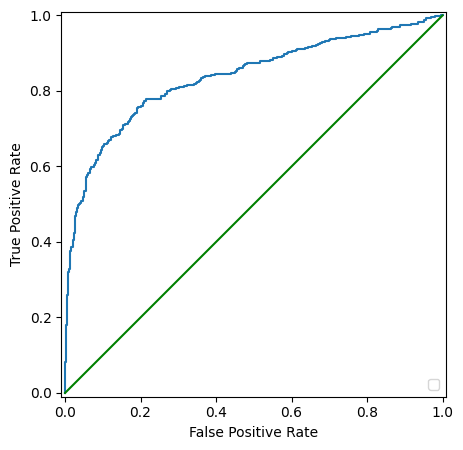

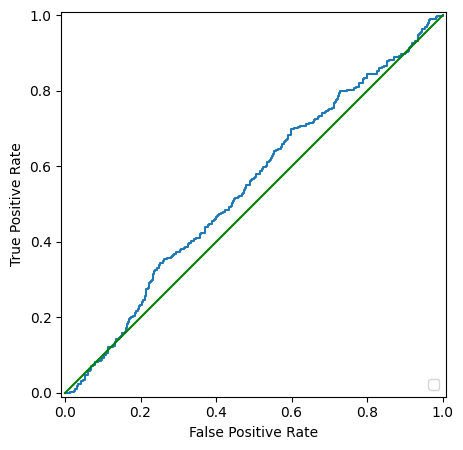

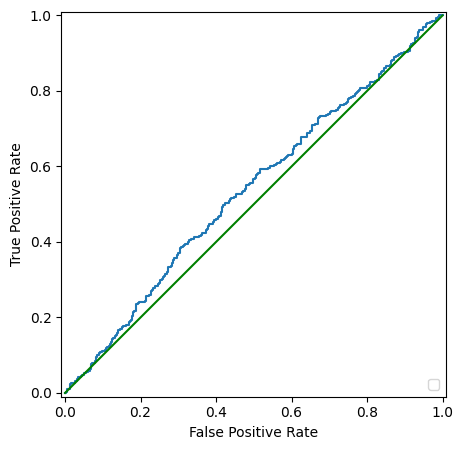

In [22]:
y_proba = VC_soft.predict_proba(X_test)
y_proba_eng = VC_soft_eng.predict_proba(X_test_eng)
Y_proba_I = VC_soft_I.predict_proba(X_test_I)
Y_proba_I_eng = VC_soft_I_eng.predict_proba(X_test_eng_I)
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
plot_auc_roc_curve(y_test, y_proba_eng[:, 1])
plot_auc_roc_curve(y_test, Y_proba_I[:, 1])
plot_auc_roc_curve(y_test, Y_proba_I_eng[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

In [26]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


# Base models (devono essere NON allenati)
base_learners = [
    ('xgb', XGBClassifier()),
    ('mlp', MLPClassifier(max_iter=10000)),
    ('lr', LogisticRegression(max_iter=200)),
    #('gb', GradientBoostingClassifier()),
    #('RandomForest', RandomForestClassifier() ),
    ('KNN', KNeighborsClassifier() ),
    #('SVC', SVC(gamma ='auto', probability = True)),
    ('AdaBoostClassifier', AdaBoostClassifier() ),
    #('ExtraTreesClassifier', ExtraTreesClassifier() )
]

# Meta-model
meta_model = LogisticRegression()

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,  # cross-validation per le predizioni dei base model
    passthrough=True,  # se True, passa anche X oltre alle predizioni al meta-model
    n_jobs=-1
)

# Fit e predizione
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

# Valutazione
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.773
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       487
           1       0.79      0.77      0.78       513

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.77      1000
weighted avg       0.77      0.77      0.77      1000



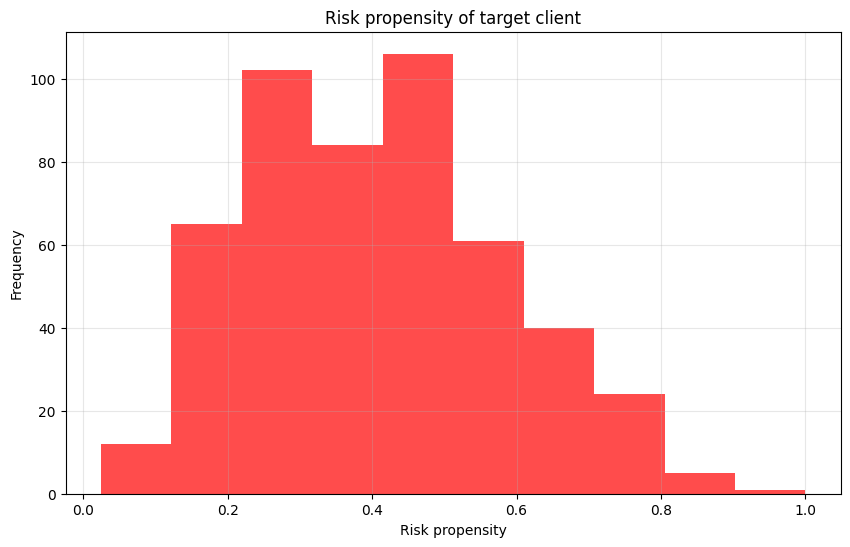


Top 10 personalized recommendations:
   ClientID  RecommendedProductID  ClientRiskPropensity  ProductRiskLevel
0      3879                     9              0.289568              0.27
1       741                     6              0.363757              0.36
2      4159                     9              0.351479              0.27
3      2352                     1              0.632490              0.55
4       827                     8              0.493311              0.48
5      1177                     9              0.326280              0.27
6      1281                     0              0.185263              0.00
7      1506                     8              0.504660              0.48
8        86                     0              0.255713              0.00
9      1243                     0              0.231562              0.00


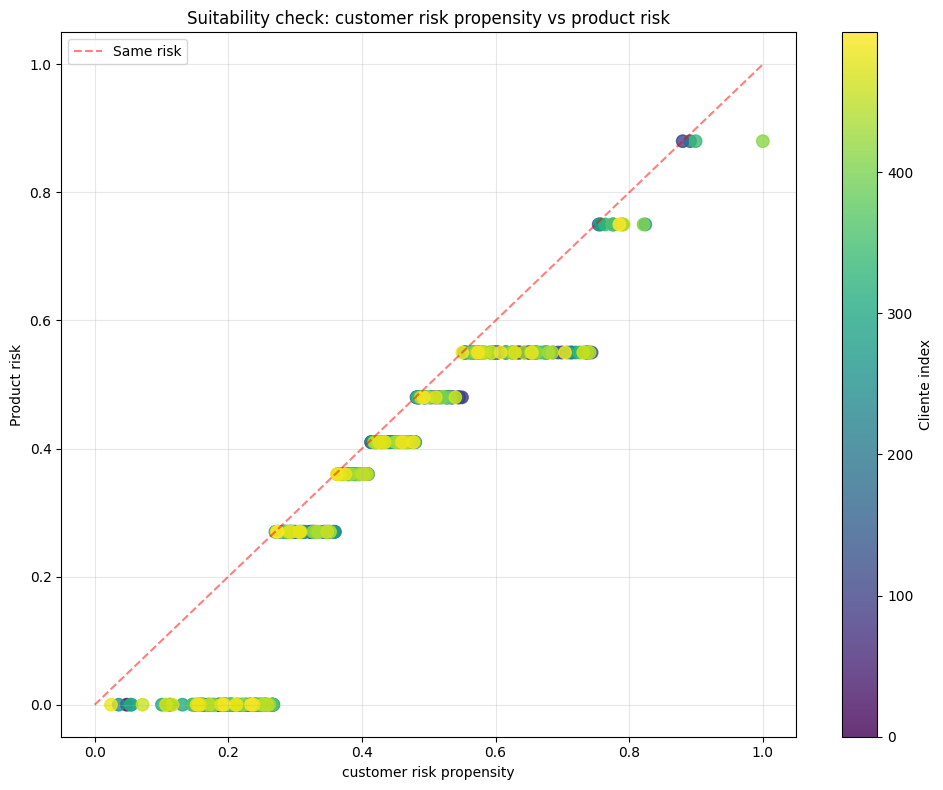

In [27]:
# Collecting client IDs and their risk propensities from the test set
# We filter for clients predicted to need accumulation products (y_pred == 1)
client_indices = np.where(y_pred == 1)[0]
target_client_ids = needs_df.iloc[X_test.index[client_indices]].index.values
target_client_risk_propensity = X_test.iloc[client_indices]['RiskPropensity'].values

# Visualizing the risk propensity distribution of target clients
plt.figure(figsize=(10, 6))
plt.hist(target_client_risk_propensity, color='r', bins=10, alpha=0.7)
plt.title('Risk propensity of target client')
plt.xlabel('Risk propensity')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Initialize lists to store recommendation results
nba_id_product = []
recommended_risk_level = []

# Extract product information for matching
product_ids = accumulation_products['IDProduct'].astype(np.uint16).values
product_risks = accumulation_products['Risk'].values

# Generate personalized recommendations for each target client
for i in range(len(target_client_risk_propensity)):
    client_risk = target_client_risk_propensity[i]

    if client_risk > min_risk:
        # Find products with acceptable risk (< customer's appetite)
        suitable_products = product_risks[product_risks < client_risk]

        if len(suitable_products) > 0:
            # Find the product with the highest risk among suitable ones
            # This maximizes potential returns while respecting risk tolerance
            max_suitable_risk = max(suitable_products)
            recommended_product_id = product_ids[product_risks == max_suitable_risk][0]
            nba_id_product.append(recommended_product_id)
            recommended_risk_level.append(max_suitable_risk)
        else:
            # No suitable products
            nba_id_product.append(0)
            recommended_risk_level.append(0)
    else:
        #  Client's risk propensity too low for any available product
        nba_id_product.append(0)
        recommended_risk_level.append(0)

# Create a comprehensive recommendation matrix
nba = pd.DataFrame({
    'ClientID': target_client_ids,
    'RecommendedProductID': nba_id_product,
    'ClientRiskPropensity': target_client_risk_propensity,
    'ProductRiskLevel': recommended_risk_level
})

# Display sample recommendations
print("\nTop 10 personalized recommendations:")
print(nba.head(10))

# Suitability Chart: customer risk propensity vs product risk
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    nba['ClientRiskPropensity'],
    nba['ProductRiskLevel'],
    c=range(len(nba)),
    cmap='viridis',
    alpha=0.8,
    s=80
)
plt.colorbar(scatter, label='Cliente index')
plt.title('Suitability check: customer risk propensity vs product risk')
plt.xlabel('customer risk propensity')
plt.ylabel('Product risk')
plt.grid(alpha=0.3)

# Add reference line for perfect risk matching
max_val = max(nba['ClientRiskPropensity'].max(), nba['ProductRiskLevel'].max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Same risk')
plt.legend()
plt.tight_layout()
plt.show()



Recommendation statistics:
Total customers analyzed: 500
Customers with valid recommendations: 373 (74.60%)
Customers without suitable recommendations: 127


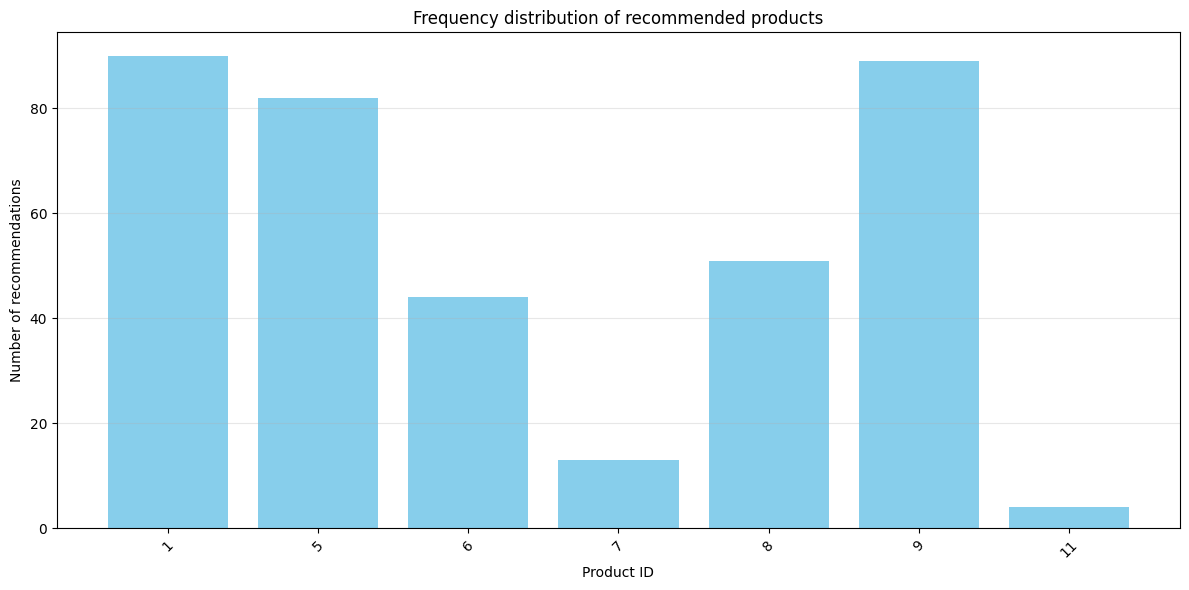


Details on the most recommended products:

Product ID: 1
Risk: 0.55
Recommended to 90 clients

Product ID: 9
Risk: 0.27
Recommended to 89 clients

Product ID: 5
Risk: 0.41
Recommended to 82 clients


In [28]:
# Analysis of recommendations
total_clients = len(nba)
clients_with_recommendations = len(nba[nba['RecommendedProductID'] > 0])
percentage_with_recommendations = (clients_with_recommendations / total_clients) * 100

print(f"\nRecommendation statistics:")
print(f"Total customers analyzed: {total_clients}")
print(f"Customers with valid recommendations: {clients_with_recommendations} ({percentage_with_recommendations:.2f}%)")
print(f"Customers without suitable recommendations: {total_clients - clients_with_recommendations}")

# Frequency distribution of recommended products
if clients_with_recommendations > 0:
    plt.figure(figsize=(12, 6))

    # Recommended products
    recommendation_counts = nba['RecommendedProductID'].value_counts().sort_index()
    recommendation_counts = recommendation_counts[recommendation_counts.index > 0]  # Escludi ID 0

    plt.bar(recommendation_counts.index.astype(str), recommendation_counts.values, color='skyblue')
    plt.title('Frequency distribution of recommended products')
    plt.xlabel('Product ID')
    plt.ylabel('Number of recommendations')
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Details on the most recommended products
    if len(recommendation_counts) > 0:
        top_products = recommendation_counts.nlargest(3).index
        print("\nDetails on the most recommended products:")
        for prod_id in top_products:
            product_details = accumulation_products[accumulation_products['IDProduct'] == prod_id]
            print(f"\nProduct ID: {prod_id}")
            print(f"Risk: {product_details['Risk'].values[0]}")
            print(f"Recommended to {recommendation_counts[prod_id]} clients")
else:
    print("\nNo products were recommended to the analyzed customers")


## now we try with stacking classifier